In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import torch
import random
import numpy as np
import pandas as pd
import meerkat as mk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import CCA
from dcbench import SliceDiscoverySolution

from domino.eval.metrics import compute_solution_metrics
from domino import explore, RareMixtureSlicer
from domino import embed

In [3]:
import os
# os.environ["DCBENCH_CONFIG"] = "/home/sabri/code/dcbench/dcbench-config.yaml"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

from tqdm import tqdm

import dcbench
sd = dcbench.tasks["slice_discovery"]

In [4]:
sd.problems

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2000,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6000,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2000,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6000,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2000,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
...,...,...,...,...,...,...
p_122649,0.2000,imagenet,5,noisy_label,[watch.n.01],timepiece.n.01
p_117333,0.0500,imagenet,5,rare,[cart.n.01],vehicle.n.01
p_118951,0.0500,imagenet,5,rare,[punch.n.02],food.n.01
p_120032,0.0500,imagenet,5,rare,[mushroom.n.05],vegetable.n.01


In [5]:
def get_slices(tasks, slice_type='rare'):
    ids = []
    print(f'Collecting {slice_type} slices:')
    for id in tqdm(tasks):
        if tasks[id]._attributes['slice_category'] == slice_type:
            ids.append(id)
    return ids

In [6]:
rare_tasks = get_slices(sd.problems, slice_type='rare')

100%|█████████████████████████████████████| 886/886 [00:00<00:00, 970021.76it/s]


In [7]:
len(rare_tasks), rare_tasks[-5:]

(118, ['p_121242', 'p_117333', 'p_118951', 'p_120032', 'p_118660'])

In [6]:
# task = 'p_121301'
task = 'p_118841'
# task = 'p_119168'
print(sd.problems[task]._attributes)
problem = sd.problems[task]

{'alpha': 0.029240177382128654, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['dessert.n.01'], 'target_name': 'food.n.01'}


In [7]:
problem

SliceDiscoveryProblem(artifacts={'activations': 'DataPanelArtifact', 'base_dataset': 'VisionDatasetArtifact', 'clip': 'DataPanelArtifact', 'model': 'ModelArtifact', 'test_predictions': 'DataPanelArtifact', 'test_slices': 'DataPanelArtifact', 'val_predictions': 'DataPanelArtifact'}, attributes={'alpha': 0.029240177382128654, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['dessert.n.01'], 'target_name': 'food.n.01'})

In [8]:
problem['test_slices']

,id (PandasSeriesColumn),slices (NumpyArrayColumn)
0,n07831146_6846,[0.0]
1,n07831146_14689,[0.0]
2,n01729322_4092,[0.0]
3,n02606052_15673,[0.0]
4,n07583066_9562,[0.0]
...,...,...
5916,n01797886_10532,[0.0]
5917,n07565083_8994,[0.0]
5918,n07697537_28542,[0.0]
5919,n07831146_2755,[0.0]


In [9]:
problem['test_predictions']

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ml/__init__.py:7: ExperimentalWarning: The `meerkat.ml` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n07831146_6846,1,"[tensor(0.0578), tensor(0.9422)]",test
1,n07831146_14689,1,"[tensor(0.0047), tensor(0.9953)]",test
2,n01729322_4092,0,"[tensor(0.9515), tensor(0.0485)]",test
3,n02606052_15673,0,"[tensor(0.9491), tensor(0.0509)]",test
4,n07583066_9562,1,"[tensor(0.1780), tensor(0.8220)]",test
...,...,...,...,...
5916,n01797886_10532,0,"[tensor(0.9650), tensor(0.0350)]",test
5917,n07565083_8994,1,"[tensor(0.4548), tensor(0.5452)]",test
5918,n07697537_28542,1,"[tensor(0.0096), tensor(0.9904)]",test
5919,n07831146_2755,1,"[tensor(0.0602), tensor(0.9398)]",test


In [10]:
problem['val_predictions']

,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n07684084_315,1,"[tensor(0.0372), tensor(0.9628)]",valid
1,n04417672_8753,0,"[tensor(0.9163), tensor(0.0837)]",valid
2,n07590611_21463,1,"[tensor(0.7959), tensor(0.2041)]",valid
3,n07932039_4035,1,"[tensor(0.5070), tensor(0.4930)]",valid
4,n02877765_11413,0,"[tensor(0.8980), tensor(0.1020)]",valid
...,...,...,...,...
2893,n01872401_1220,0,"[tensor(0.7960), tensor(0.2040)]",valid
2894,n07836838_353,1,"[tensor(0.2065), tensor(0.7935)]",valid
2895,n02028035_3365,0,"[tensor(0.9858), tensor(0.0142)]",valid
2896,n07930864_105,1,"[tensor(0.8773), tensor(0.1227)]",valid


In [11]:
test_dp = mk.merge(problem["test_slices"], problem["test_predictions"], on="id")
test_dp = mk.merge(problem["base_dataset"], test_dp, on="id")
test_dp["pred"] = test_dp["probs"][:, 1]

val_dp = mk.merge(problem["val_predictions"], problem["base_dataset"], on="id") 
val_dp["pred"] = val_dp["probs"][:, 1]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


## Embed Images

In [12]:
# val_dp = embed(
#     val_dp, 
#     input_col="image",
#     device=0
# )
# test_dp = embed(
#     test_dp, 
#     input_col="image",
#     device=0
# )

In [13]:
test_dp.columns

['id', 'image', 'name', 'synset', 'slices', 'target', 'probs', 'split', 'pred']

## Embed Text

In [14]:
from domino import generate_candidate_descriptions
phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates,
    num_candidates=10_000
)

[nltk_data] Downloading package words to
[nltk_data]     /home/namratadeka/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [15]:
text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=0
)

  0%|          | 0/79 [00:00<?, ?it/s]

## Load embeddings

In [16]:
emb_dp = mk.DataPanel.read("image_embs.mk")

In [17]:
val_dp.columns

['id', 'target', 'probs', 'split', 'image', 'name', 'synset', 'pred']

In [18]:
emb_dp.columns

['id', 'image', 'name', 'synset', 'clip(image)']

In [19]:
val_dp = val_dp.merge(emb_dp["id", "clip(image)"], on="id", how="left")
test_dp = test_dp.merge(emb_dp["id", "clip(image)"], on="id", how="left")

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [21]:
from sklearn.cross_decomposition import CCA

[autoreload of sklearn.utils.fixes failed: Traceback (most recent call last):
  File "/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/namratadeka/anaconda3/envs/domino/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/sklearn/utils/fixes.py", line 47, in <module>
    class loguniform(scipy.stats.reciprocal):
  File "/home/namratadeka/anaconda3/envs/domino/lib/python

## Slice

In [39]:
config = {
    'y_log_likelihood_weight':10,
    'y_hat_log_likelihood_weight':10,
    'error_weight': 0,
    'n_mixture_components':25,
    'n_slices': 25,
    'weight_by_error': True
}
slicer = RareMixtureSlicer(
    **config
)

In [40]:
slicer.fit(data=val_dp, embeddings="clip(image)", targets="target", pred_probs="pred")

  0%|          | 0/100 [00:00<?, ?it/s]

RareMixtureSlicer(error_weight=0, n_slices=25, weight_by_error=True,
                  y_hat_log_likelihood_weight=10, y_log_likelihood_weight=10)

In [41]:
result = mk.DataPanel({"id": test_dp["id"]})

In [42]:
result['slice_preds'] = slicer.predict(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )
result['slice_probs'] = slicer.predict_proba(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )

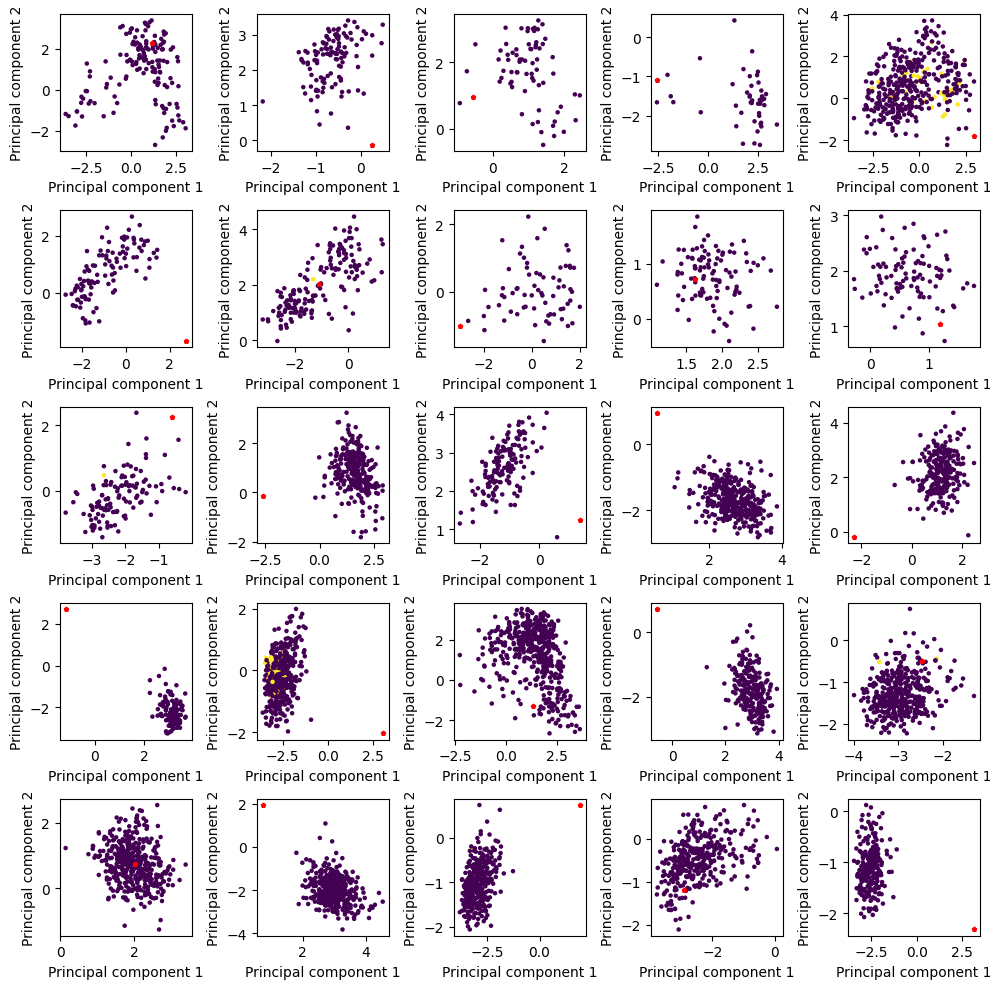

In [43]:
pca = PCA(n_components=2)
test_X = slicer.pca.transform(test_dp['clip(image)'])
test_X = pca.fit_transform(np.vstack([test_X, slicer.mm.means_]))
centers = test_X[-slicer.config.n_slices:]
test_X = test_X[:-slicer.config.n_slices]

plt.figure(figsize=(10, 10))
for i in range(slicer.config.n_slices):
    plt.subplot(5, 5, i+1)
    cluster = i
    points = test_X[result['slice_preds'].argmax(axis=1)==cluster]
    colors = test_dp[result["slice_preds"].argmax(axis=1)==cluster]['slices'].reshape(-1,)

    plt.scatter(points[:,0], points[:, 1], s=5, c=colors)
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=10, c='r', marker='p', label='cluster centers')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')

plt.tight_layout()
plt.show()

In [44]:
test_dp['rare_slices'] = result["slice_preds"]
explore(
    data=test_dp,
    embeddings="clip(image)",
    pred_probs="probs",
    targets="target",
    slices="rare_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
) 

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()

In [45]:
solution = SliceDiscoverySolution(
    artifacts={
        "pred_slices": result,
    },
    attributes={
        "problem_id": problem.id,
        "slicer_class": RareMixtureSlicer,
        "slicer_config": config,
        "embedding_column": 'clip(image)',
    },
)
metrics = compute_solution_metrics(
    solution,
)

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [46]:
metrics

[{'target_slice_idx': 0,
  'target_slice_name': 'dessert.n.01',
  'pred_slice_idx': 4,
  'average_precision': 0.20017879547198414,
  'precision-at-10': 1.0,
  'precision-at-25': 0.6,
  'precision': 0.08395061728395062,
  'recall': 0.4146341463414634,
  'f1_score': 0.13963039014373715,
  'support': None,
  'solution_id': '6dd11ac1b6534523bdf9818facb29be7',
  'problem_id': 'p_118841'}]

In [73]:
config = {
    'n_slices': 25,
    'n_mixture_components': 25,
    'max_iter': 100,
    'error_weight': 0,
}
res = {
    'domino': [],
    'entropy': []
}
weights = [0, 1, 5, 10, 20, 100]
for weight in weights:
    config['y_log_likelihood_weight'] = weight
    config['y_hat_log_likelihood_weight'] = weight
    for entropy in [False, True]:
        config['weight_by_error'] = entropy
        np.random.seed(0)
        torch.manual_seed(0)
        random.seed(0)
        slicer = RareMixtureSlicer(
            **config
        )
        slicer.fit(data=val_dp, embeddings="clip(image)", targets="target", pred_probs="pred")
        result = mk.DataPanel({"id": test_dp["id"]})
        result['slice_preds'] = slicer.predict(
            test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
        )
        result['slice_probs'] = slicer.predict_proba(
            test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
        )
        solution = SliceDiscoverySolution(
        artifacts={
            "pred_slices": result,
        },
        attributes={
            "problem_id": problem.id,
            "slicer_class": RareMixtureSlicer,
            "slicer_config": config,
            "embedding_column": 'clip(image)',
        },
        )
        metrics = compute_solution_metrics(
            solution,
        )
        if entropy:
            res['entropy'].append(metrics[0]['precision-at-10'])
        else:
            res['domino'].append(metrics[0]['precision-at-10'])

  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


  0%|          | 0/100 [00:00<?, ?it/s]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


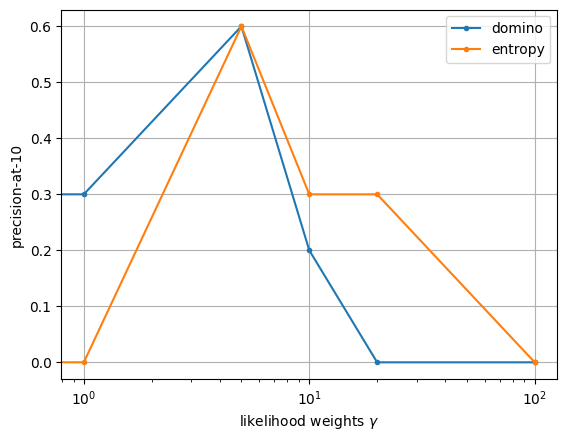

In [74]:
plt.plot(weights, res['domino'], label='domino', marker='.')
plt.plot(weights, res['entropy'], label='entropy', marker='.')
plt.xscale('log')
plt.grid(which='major')
plt.legend()
plt.ylabel('precision-at-10')
plt.xlabel(r'likelihood weights $\gamma$')
plt.show()

In [41]:
pred_slices = result["slice_preds"].argmax(axis=1)

In [42]:
np.unique(pred_slices[np.where(test_dp['slices'] == 1)[0]])

array([ 0, 22])

,id (PandasSeriesColumn),image (ListColumn),name (PandasSeriesColumn),synset (PandasSeriesColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn),pred (ClassificationOutputColumn),clip(image) (NumpyArrayColumn),kcenter_slices (NumpyArrayColumn)
0,n02125311_1630,,"cougar, puma, catamount, mountain lion, painter, panther, Felis concolor",n02125311,[0.0],0,"[tensor(0.2157), tensor(0.7843)]",test,tensor(0.7843),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1,n02128925_14926,,"jaguar, panther, Panthera onca, Felis onca",n02128925,[0.0],1,"[tensor(0.8932), tensor(0.1068)]",test,tensor(0.1068),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
2,n02128925_16213,,"jaguar, panther, Panthera onca, Felis onca",n02128925,[0.0],1,"[tensor(0.9277), tensor(0.0723)]",test,tensor(0.0723),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
3,n02128925_63835,,"jaguar, panther, Panthera onca, Felis onca",n02128925,[0.0],1,"[tensor(0.9691), tensor(0.0309)]",test,tensor(0.0309),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
4,n02129165_10790,,"lion, king of beasts, Panthera leo",n02129165,[1.0],1,"[tensor(0.7618), tensor(0.2382)]",test,tensor(0.2382),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
...,...,...,...,...,...,...,...,...,...,...,...
12,n02129165_7860,,"lion, king of beasts, Panthera leo",n02129165,[1.0],1,"[tensor(0.8400), tensor(0.1600)]",test,tensor(0.1600),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
13,n02129165_9129,,"lion, king of beasts, Panthera leo",n02129165,[1.0],1,"[tensor(0.7427), tensor(0.2573)]",test,tensor(0.2573),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
14,n02129165_927,,"lion, king of beasts, Panthera leo",n02129165,[1.0],1,"[tensor(0.7454), tensor(0.2546)]",test,tensor(0.2546),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
15,n02130308_13842,,"cheetah, chetah, Acinonyx jubatus",n02130308,[0.0],1,"[tensor(0.0572), tensor(0.9428)]",test,tensor(0.9428),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"

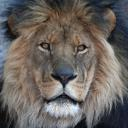
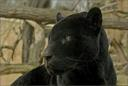
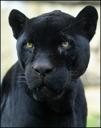
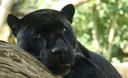
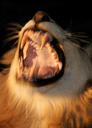
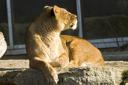
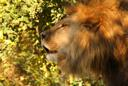
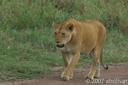
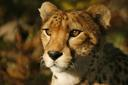
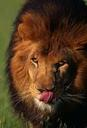

In [45]:
test_dp[pred_slices==0]